# Cell-Cell interaction Analysis using NCEM  
### Spatial pancreas  
Subset of a non-diabetic slide (fov == 12) 

### Pre-requisites

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np

import scanpy as sc
import squidpy as sq
import ncem as nc

import matplotlib.pyplot as plt

sc.settings.set_figure_params(dpi=80, facecolor="white")

2024-07-23 15:02:03.030251: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-23 15:02:03.230033: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-23 15:02:06.320220: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-23 15:02:11.455216: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-23 15:02:46.330728: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [2]:
nc.__version__

'0.1.5'

### Load data

In [28]:
folder = '/lustre/groups/ml01/workspace/sara.jimenez/spatial_pancreas_data/preprocessed_data/data4downstream/'
file   = 'S1_niche_label_annotated.h5ad' #'imputed_envi.h5ad'
adata_s1 = sc.read(folder+file)
adata_s1

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 104816 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'niche_label'
    uns: 'cell_type_coarse_colors', 'spatial', 'spatial_neighbors'
    obsm: 'spatial', 'spatial_fov'
    layers: 'counts'

In [29]:
adata_s1.obs['niche_label'].cat.categories

Index(['Acinar_Ductal', 'Acinar_enriched', 'Alpha_enriched', 'Beta_enriched',
       'Ductal_enriched', 'Endocrine_Exocrine', 'Mast_enriched',
       'Support_cells'],
      dtype='object')

In [30]:
adata_s1.uns['niche_label_colors'] = [
    '#867A1D', #Acinar_Ductal
    '#edd892', #Acinar_enriched
    '#219ebc', #Alpha_enriched
    '#adc178', #Beta_enriched
    '#f79824', #Ductal_enriched
    '#718355', #Endocrine_Exocrine
    '#582f0e', #Mast_enriched
    '#bbd0ff', #Support_cells
]

In [ ]:
markers={
    'Acinar':['CPB1','EGF','SPINK1'],
    'Alpha':['GCG','TTR'],
    'Beta':['INS','IAPP'],
    'Ductal':['SOX9','KRT19','SPP1'],
    'Endothelial':['PECAM1','VWF','ENG'],
    'Fibroblast':['COL3A1','COL1A1','MGP'],
    'Immune':['CD163','ITGB2','C1QB']
}

In [ ]:
sc.pl.matrixplot(adata_s1, markers,groupby='cell_type_coarse', cmap='Greys',standard_scale='var')

In [31]:
adata = adata_s1[np.isin(adata_s1.obs['fov'],['12'])].copy()
adata

AnnData object with n_obs × n_vars = 5208 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'niche_label'
    uns: 'cell_type_coarse_colors', 'spatial', 'spatial_neighbors', 'niche_label_colors'
    obsm: 'spatial', 'spatial_fov'
    layers: 'counts'

In [32]:
adata.uns['cell_type_coarse_colors'] = [
    '#edd892', #acinar
    '#219ebc', #alpha
    '#adc178', #beta
    '#f79824', #ductal
    '#718355', #endocrine
    '#f15156', #endothelial
    '#bbd0ff', #Fibroblasts
    '#979dac', #Immune
    '#582f0e'  #mast
]

### Data Exploration

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)


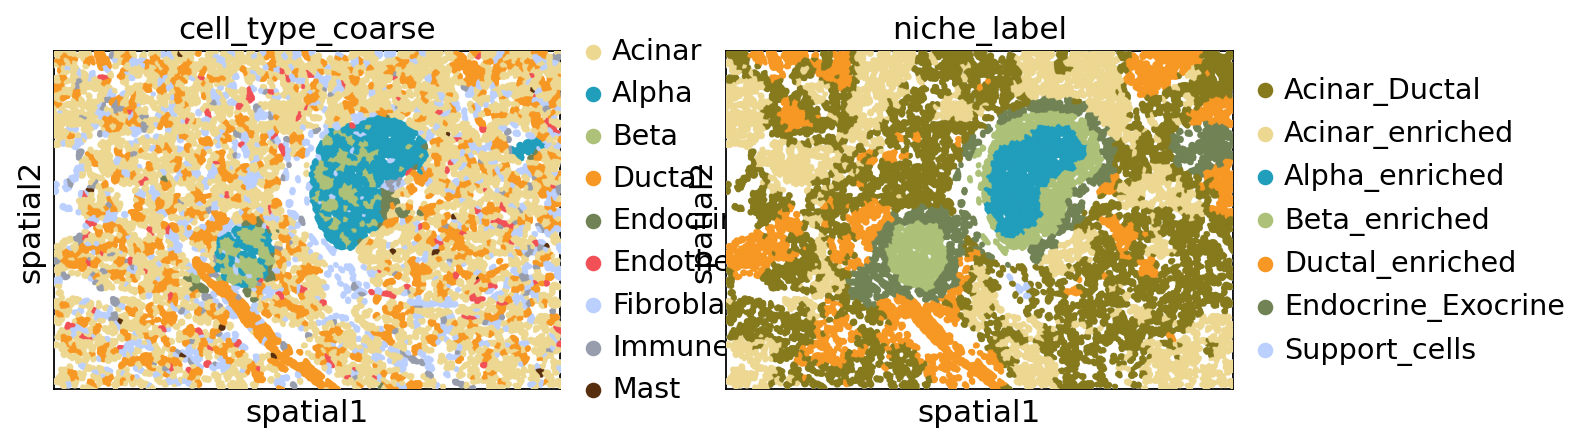

In [33]:
sq.pl.spatial_segment(adata,color=['cell_type_coarse','niche_label'],ncols=2,
                      library_key='fov', seg_cell_id='cell_ID',cmap='RdYlBu_r', img=False)

In [34]:
from matplotlib.pyplot import rc_context

In [ ]:
HORMONES = ['INS','GCG','SST']
#adata.uns['cell_type_coarse_colors'] = ['#00bbf9', '#a7c957', '#F4BA41', '#e63946', '#6c757d', '#ffcdb2','#fb8500']

In [ ]:
# Check expression of known markers to get intuition of the dataset
with rc_context({'figure.figsize': (10.5,7)}):
    sc.pl.embedding(
        adata,
        basis='spatial',
        color=HORMONES,
        vmin=0,
        vmax='p99',  
        sort_order=False,  
        frameon=False,
        cmap='RdYlBu_r', 
        size=150,ncols=3
    )

In [35]:
type(adata.X)

scipy.sparse._csr.csr_matrix

In [36]:
adata.X = adata.X.toarray()

1. Noise distribution of the dataset per cell type 
- NCEM requires gaussian distribution not negative binomial 
- Important not to overnormalized -> the 

Acinar
Alpha
Beta
Ductal
Endocrine
Endothelial
Fibroblasts
Immune
Mast


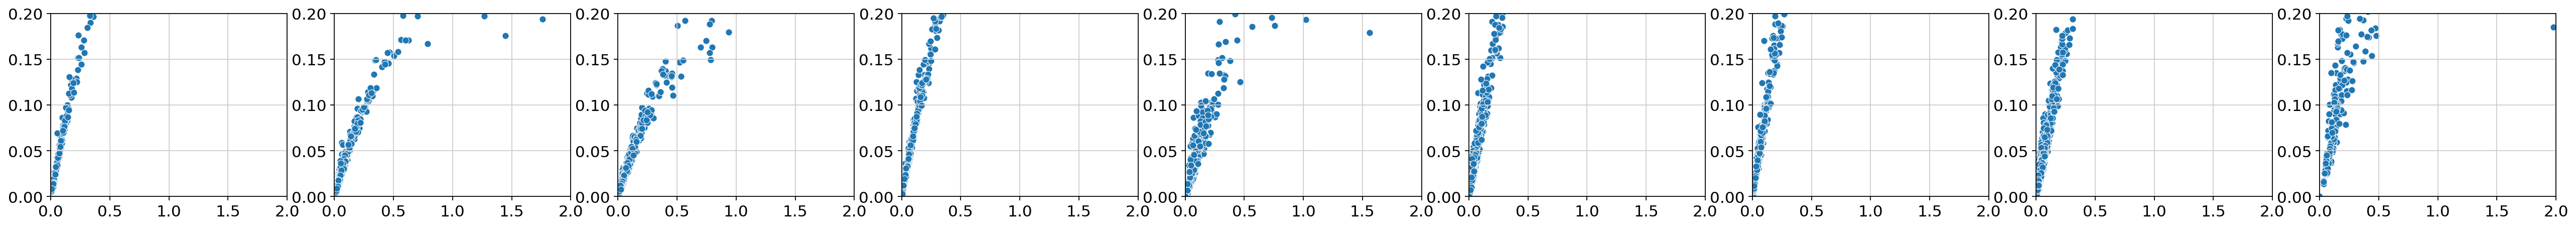

In [37]:
fig, ax = plt.subplots(1,len(np.unique(adata.obs['cell_type_coarse'])), figsize=(40,3))
for i, ct in enumerate(np.unique(adata.obs['cell_type_coarse'])):
    print(ct)
    mean = np.mean(adata[adata.obs['cell_type_coarse']==ct].X, axis=0)
    var = np.var(adata[adata.obs['cell_type_coarse']==ct].X, axis=0)
    g=sns.scatterplot(x=mean, y=var, ax=ax[i])
    g.set(ylim=(0, 0.2), xlim=(0,2))

In [38]:
adata.obs['cell_type_coarse'].cat.categories

Index(['Acinar', 'Alpha', 'Beta', 'Ductal', 'Endocrine', 'Endothelial',
       'Fibroblasts', 'Immune', 'Mast'],
      dtype='object')

### Pre-processing

In [39]:
adata.X.max()

4.3965755

In [40]:
adata.layers['counts'].max()

177

#### the data seems normalized
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
adata.X

In [41]:
# calculating node degree for several distances 
for rd in [0,35,50,110,180,500]:
    connectivities, _ = sq.gr.spatial_neighbors(
        adata, radius=rd, coord_type='generic', copy=True
    )
    print(np.mean(np.sum(connectivities, axis=0)))

0.0
0.23732718894009217
1.2645929339477726
9.872119815668203
26.92089093701997
192.69009216589862


In [42]:
sq.gr.spatial_neighbors(
    adata,
    n_neighs=50,
    coord_type="generic",
    delaunay=True,
    library_key='fov'
)

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_color_utils.py:27: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  target.uns[color_key] = source.uns[color_key]
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)


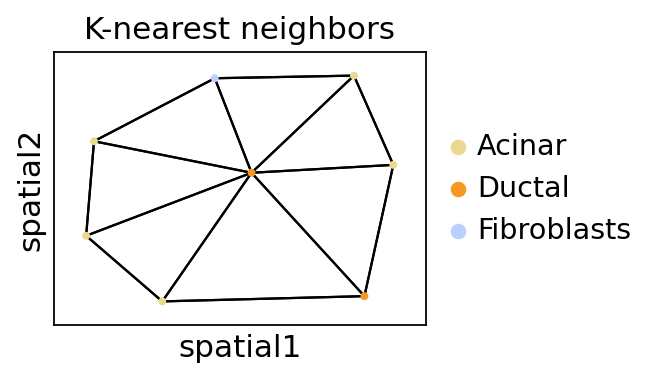

In [43]:
_, idx = adata.obsp["spatial_connectivities"][420, :].nonzero()
idx = np.append(idx, 420)
sq.pl.spatial_scatter(
    adata[idx,420],
    library_id = '12',
    color="cell_type_coarse",
    connectivity_key="spatial_connectivities",
    size=3,
    edges_width=1,
    edges_color="black",
    img=False,
    title="K-nearest neighbors"
)

### Neighbors enrichment analysis

In [44]:
sq.gr.nhood_enrichment(adata,cluster_key='cell_type_coarse')

100%|██████████| 1000/1000 [00:02<00:00, 357.09/s]


/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_utils.py:557: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]


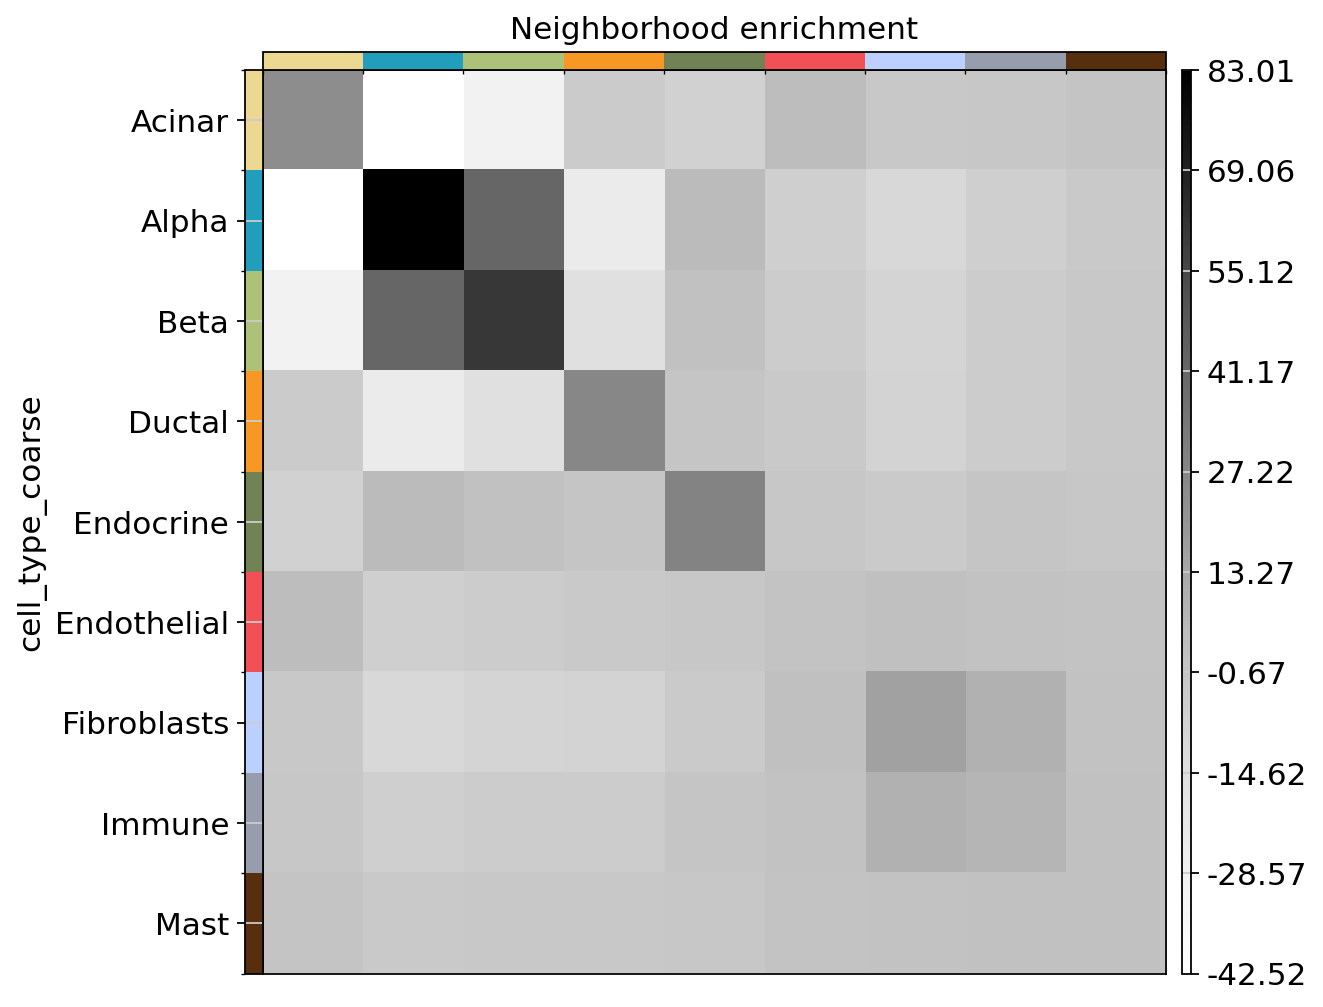

In [45]:
sq.pl.nhood_enrichment(adata, cluster_key='cell_type_coarse',cmap='Greys')

In [46]:
sq.gr.interaction_matrix(adata, cluster_key='cell_type_coarse',weights=True)

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_utils.py:557: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]


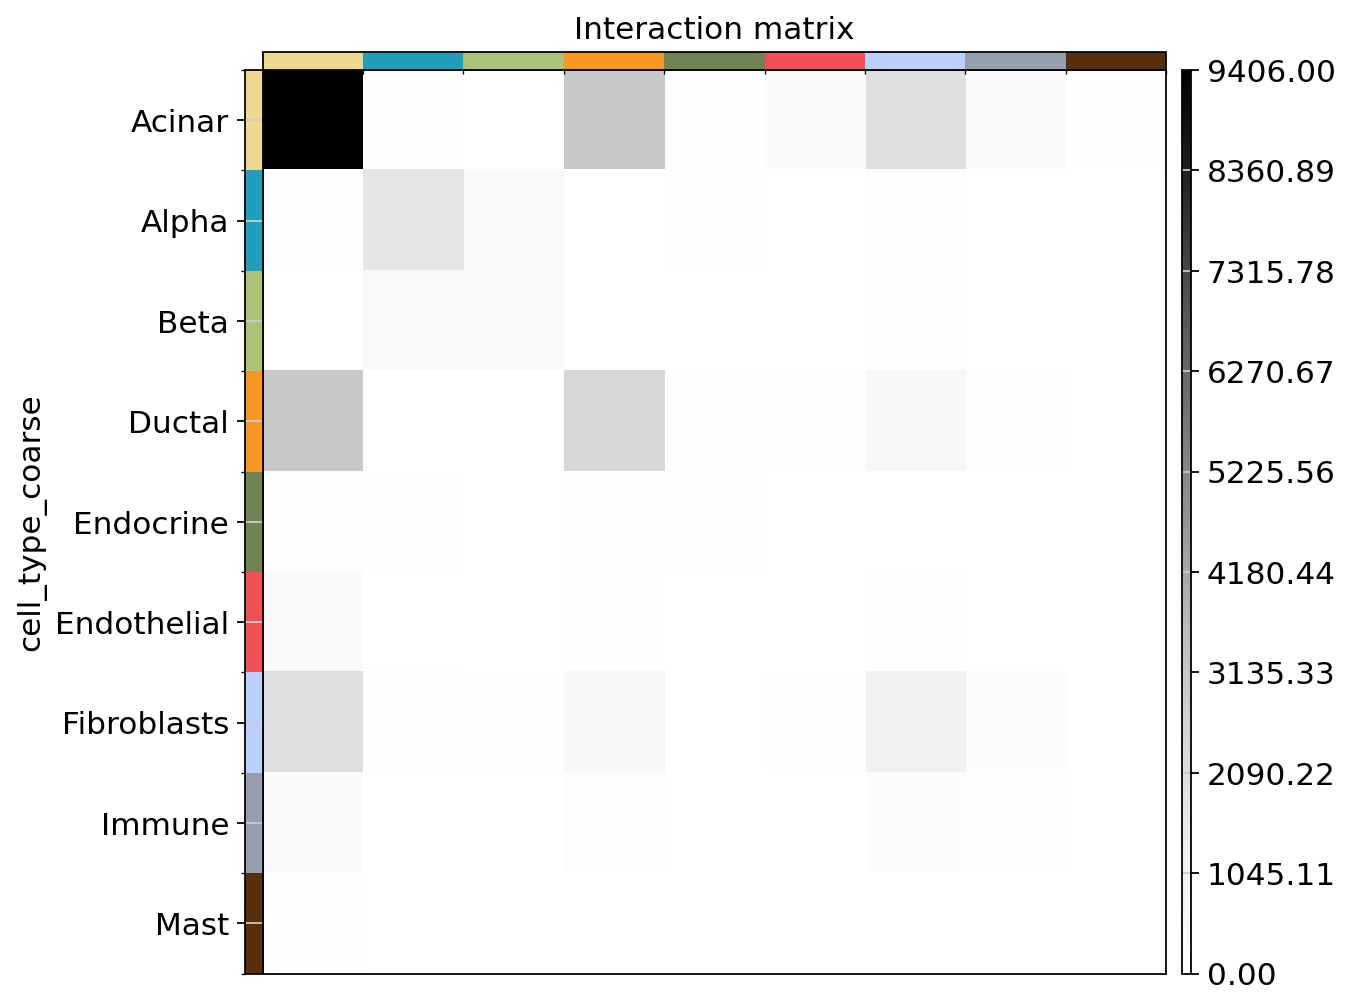

In [47]:
sq.pl.interaction_matrix(adata, cluster_key='cell_type_coarse',cmap='Greys')

### Compute Ripley’s statistics
The Ripley’s L function is a descriptive statistics generally used to determine whether points have a random, dispersed or clustered distribution pattern at certain scale.

In [ ]:
mode = "L"
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

sq.gr.ripley(adata, cluster_key="cell_type_coarse", mode=mode)
sq.pl.ripley(
    adata,
    cluster_key="cell_type_coarse",
    mode=mode,
    ax=ax[0],
)

sq.pl.spatial_segment(
    adata,
    shape="hex",
    color="cell_type_coarse",
    library_id="12",
    library_key="fov",
    seg_cell_id="cell_ID",
    img=False,
    size=60,
    ax=ax[1],
)

### Moran’s I score

The Moran’s I global spatial auto-correlation statistics evaluates whether features (i.e. genes) shows a pattern that is clustered, dispersed or random in the tissue are under consideration.

In [ ]:
#sq.gr.spatial_neighbors(adata, coord_type="generic", delaunay=True)
sq.gr.spatial_autocorr(
    adata,
    mode="moran",
    n_perms=100,
    n_jobs=1,
)
adata.uns["moranI"].head(10)

In [ ]:
adata.uns["moranI"].head(10).index.values

In [ ]:
adata.obs.cell_type_coarse.value_counts()

In [ ]:
sc.pl.matrixplot(adata, adata.uns["moranI"].head(10).index.values, groupby='cell_type_coarse', cmap='Greys')
#mp.add_totals().style(edge_color='black').show()

In [ ]:
sq.pl.spatial_segment(
    adata,
    library_id="10",
    seg_cell_id="cell_ID",
    library_key="fov",
    color=["GCG", "INS", "CPB1","SPINK1"],
    size=60,
    img=False,cmap="RdYlBu_r"
)

### Ligand receptor analysis

In [ ]:
sq.gr.ligrec(adata,cluster_key='cell_type_coarse',use_raw=False, alpha=0.005)

In [ ]:
sq.pl.ligrec(adata, cluster_key='cell_type_coarse',pvalue_threshold=0.0001,
             remove_nonsig_interactions=True, remove_empty_interactions=True,figsize = (10,10))

### NCEM

In [48]:
from ncem.tl.fit.glm import linear_ncem

In [ ]:
linear_ncem

In [56]:
adata = linear_ncem(adata=adata, key_type='niche_label', key_graph='spatial_connectivities')

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [57]:
adata.obs['niche_label'].cat.categories

Index(['Acinar_Ductal', 'Acinar_enriched', 'Alpha_enriched', 'Beta_enriched',
       'Ductal_enriched', 'Endocrine_Exocrine', 'Support_cells'],
      dtype='object')

In [58]:
adata

AnnData object with n_obs × n_vars = 5208 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'niche_label'
    uns: 'cell_type_coarse_colors', 'spatial', 'spatial_neighbors', 'niche_label_colors', 'cell_type_coarse_nhood_enrichment', 'cell_type_coarse_interactions', 'ncem'
    obsm: 'spatial', 'spatial_fov', 'ncem_niche', 'ncem_dmat'
    varm: 'ncem_params', 'ncem_tested_params', 'ncem_pvals', 'ncem_fdr_pvals'
    layers: 'counts'
    obsp: 'spatial_conn

#### Exploring interesting interactions

In [59]:
adata.varm['ncem_params']

,index_Acinar_Ductal,index_Acinar_enriched,index_Alpha_enriched,index_Beta_enriched,index_Ductal_enriched,index_Endocrine_Exocrine,index_Support_cells,index_Acinar_Ductal:neighbor_Acinar_Ductal,index_Acinar_enriched:neighbor_Acinar_Ductal,index_Alpha_enriched:neighbor_Acinar_Ductal,...,index_Ductal_enriched:neighbor_Endocrine_Exocrine,index_Endocrine_Exocrine:neighbor_Endocrine_Exocrine,index_Support_cells:neighbor_Endocrine_Exocrine,index_Acinar_Ductal:neighbor_Support_cells,index_Acinar_enriched:neighbor_Support_cells,index_Alpha_enriched:neighbor_Support_cells,index_Beta_enriched:neighbor_Support_cells,index_Ductal_enriched:neighbor_Support_cells,index_Endocrine_Exocrine:neighbor_Support_cells,index_Support_cells:neighbor_Support_cells
AATK,1.122734e-01,0.036092,0.044547,0.034041,0.089619,0.022970,3.724017e-15,-0.086495,-0.014863,7.143602e-16,...,-0.012539,0.028209,0.0,0.053372,0.0,0.0,0.0,0.0,0.0,-4.114057e-15
ABL1,6.528156e-02,0.033082,0.030262,0.033938,0.014952,-0.015141,4.366788e-16,-0.021943,0.007724,-3.196357e-16,...,-0.003873,0.037255,0.0,0.033640,0.0,0.0,0.0,0.0,0.0,4.031330e-15
ABL2,1.732060e-01,0.100731,0.024014,0.025947,0.231058,0.020309,1.269122e-14,-0.067457,0.024433,1.551729e-15,...,0.071617,0.107048,0.0,-0.080280,0.0,0.0,0.0,0.0,0.0,-1.799718e-14
ACE,2.139616e-03,0.068234,0.017986,0.013013,0.023392,-0.017644,-1.675169e-14,0.011877,-0.010014,-1.038098e-16,...,0.006135,0.024837,0.0,-0.017687,0.0,0.0,0.0,0.0,0.0,3.608177e-14
ACE2,6.480858e-02,-0.004840,0.021211,0.012606,0.102988,0.024939,3.081104e-15,-0.043521,0.003287,1.129877e-15,...,-0.024988,0.005167,0.0,0.007875,0.0,0.0,0.0,0.0,0.0,-5.510707e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NegPrb19,-6.191819e-07,0.052651,0.001548,0.011964,0.036384,0.005671,6.962312e-16,0.012064,-0.013835,4.330002e-16,...,0.002811,0.003832,0.0,-0.013860,0.0,0.0,0.0,0.0,0.0,8.711390e-17
NegPrb20,-7.934102e-04,-0.001063,0.007809,0.015620,0.025645,0.007140,1.278930e-15,0.019440,0.005990,-1.034821e-16,...,0.005591,0.040555,0.0,-0.018627,0.0,0.0,0.0,0.0,0.0,-1.083196e-15
NegPrb21,2.414998e-03,0.024925,0.007878,0.005929,0.040478,-0.004472,3.537171e-16,0.009037,-0.000063,2.710163e-16,...,-0.011340,0.013534,0.0,-0.010901,0.0,0.0,0.0,0.0,0.0,4.244998e-16
NegPrb22,-1.393466e-03,0.031746,0.010222,0.010823,0.074527,0.002991,4.845295e-15,0.023549,-0.009819,6.263295e-16,...,0.028433,0.016459,0.0,-0.026032,0.0,0.0,0.0,0.0,0.0,-7.483130e-15


In [60]:
#df = pd.DataFrame(np.sum(np.absolute(adata.varm['ncem_fdr_pvals']<0.05)))
df = pd.DataFrame(np.sum(np.absolute(adata.varm['ncem_params'])))
df_int = pd.DataFrame(columns=adata.obs['niche_label'].cat.categories, index=adata.obs['niche_label'].cat.categories,dtype=float)
for s in adata.obs['niche_label'].cat.categories:
    for r in adata.obs['niche_label'].cat.categories: 
        index_value = 'index_'+s+':neighbor_'+r
        df_int.at[s,r] = df.loc[index_value][0]
df_int

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


,Acinar_Ductal,Acinar_enriched,Alpha_enriched,Beta_enriched,Ductal_enriched,Endocrine_Exocrine,Support_cells
Acinar_Ductal,3.322837e+01,7.010329e+00,9.209380e-14,7.588920e+01,7.446062,14.365636,61.574248
Acinar_enriched,7.415905e+00,2.333674e+01,2.613926e-13,3.165657e-14,22.595785,21.922052,0.000000
Alpha_enriched,3.425393e-12,2.689515e-13,3.789528e+01,1.580998e+01,0.000000,82.032811,0.000000
Beta_enriched,6.874993e+01,1.023238e-13,2.209823e+01,3.766744e+01,0.000000,31.903735,0.000000
Ductal_enriched,1.626145e+01,2.398880e+01,1.845912e-13,2.148199e-16,30.562086,19.997119,0.000000
Endocrine_Exocrine,1.830426e+01,2.674316e+01,1.239416e+02,1.515918e+01,19.955382,115.887288,0.000000
Support_cells,3.954573e+01,4.847162e-13,4.229239e-13,0.000000e+00,0.000000,0.000000,125.757404


In [61]:
import seaborn as sns

<Axes: >

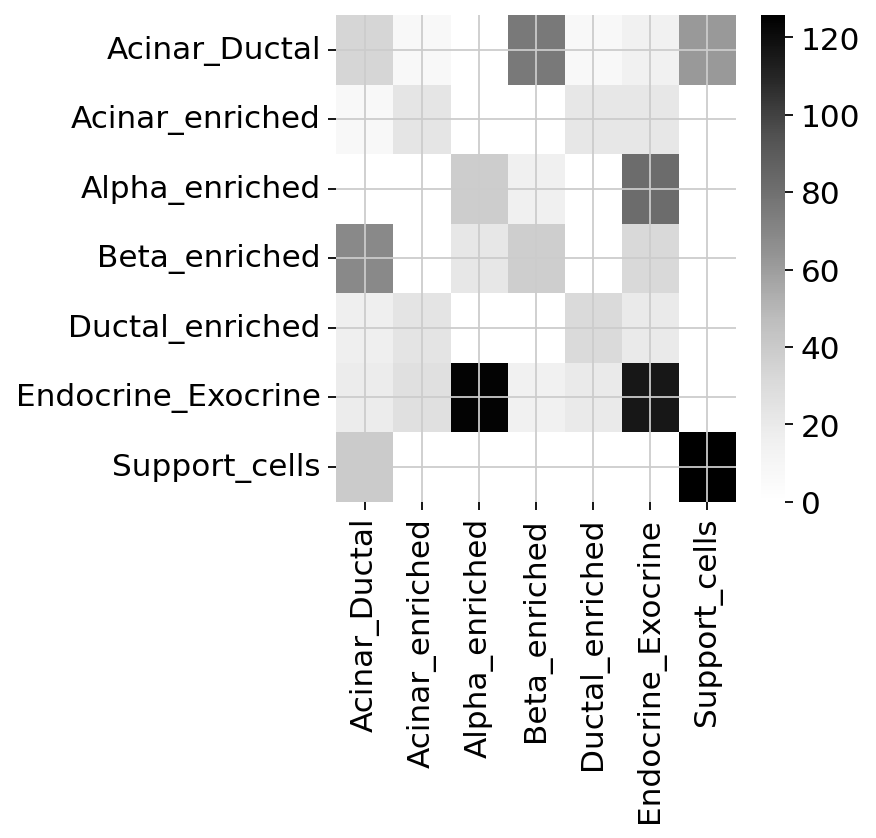

In [62]:
sns.heatmap(
            df_int,
            cmap="Greys",
        )

In [63]:
interactions = [
    'index_Acinar_Ductal:neighbor_Beta_enriched'
]

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite va

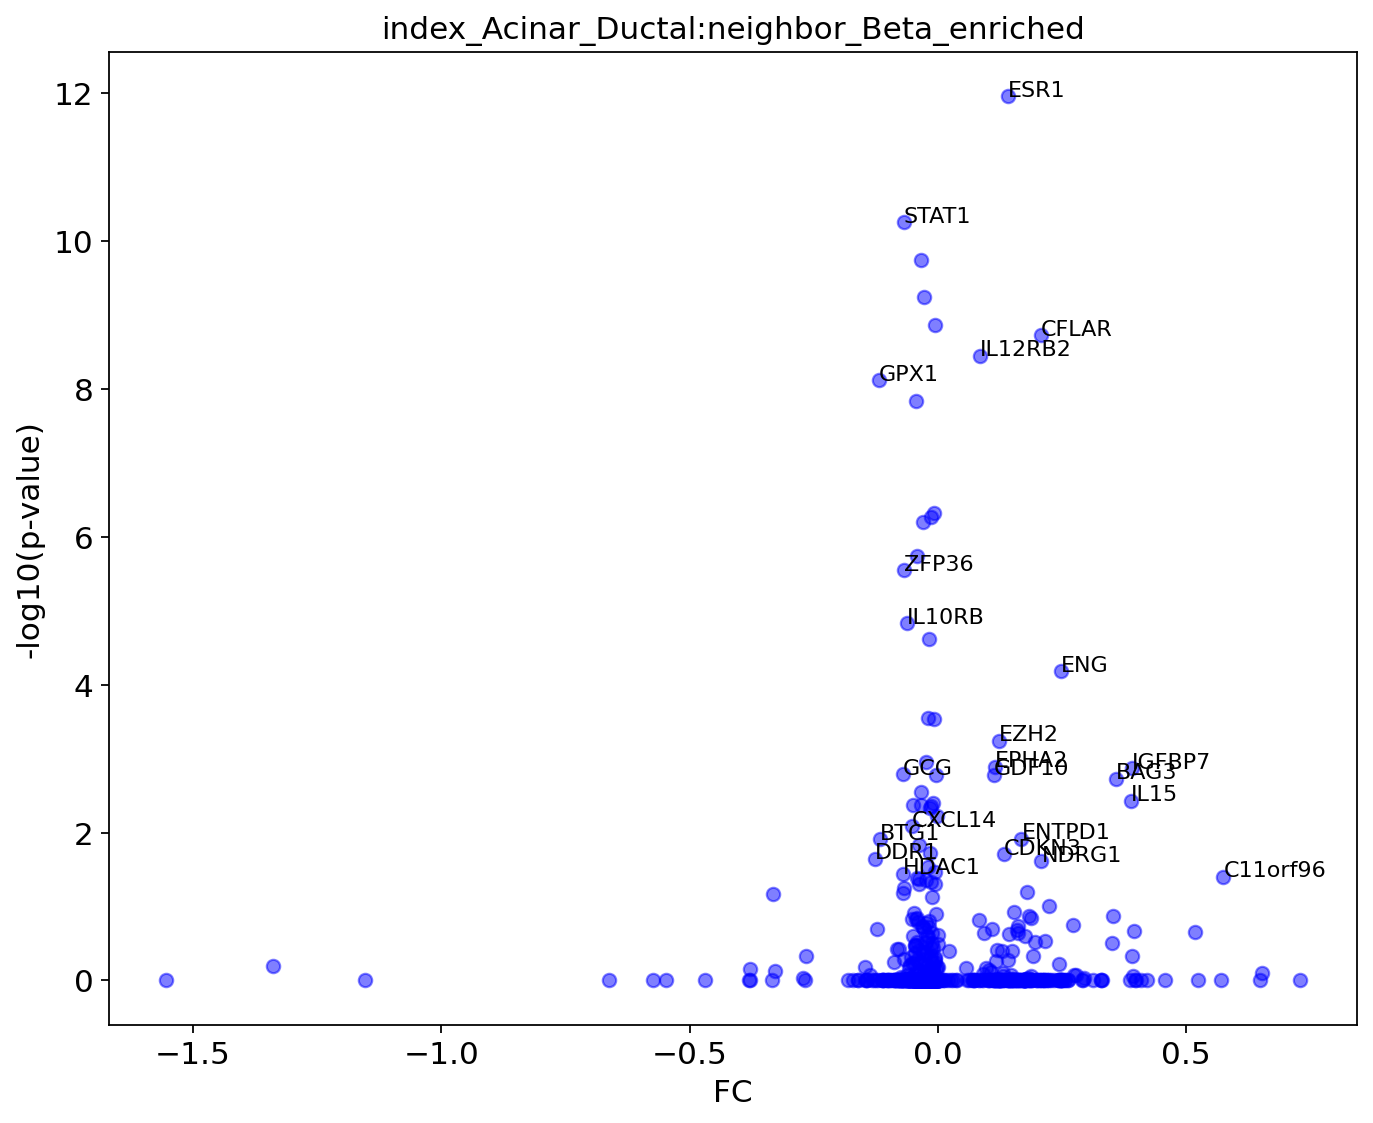

In [64]:
for c in interactions:
    data_df = {
        'log2FoldChange' : adata.varm['ncem_params'][c],
        'padj' : adata.varm['ncem_fdr_pvals'][c],
        'symbol' : np.array(adata.varm['ncem_fdr_pvals'].index)
    }
    
    df = pd.DataFrame(data_df)
    
    df['-log10(p_value)'] = -np.log10(df['padj'])
    

    plt.figure(figsize=(10, 8))
    plt.scatter(df['log2FoldChange'], df['-log10(p_value)'], color='blue', alpha=0.5)
    
    # Label the most significant points
    threshold_logFC = 0.05  # Adjust as needed
    threshold_p_value = 0.05  # Adjust as needed
    significant_points = df[(abs(df['log2FoldChange']) >= threshold_logFC) & (df['padj'] <= threshold_p_value)]
    for i, point in significant_points.iterrows():
        plt.text(point['log2FoldChange'], point['-log10(p_value)'], point['symbol'], fontsize=10)
        #volcano(df)
        
    # Add labels and title
    plt.xlabel('FC')
    plt.ylabel('-log10(p-value)')
    plt.title(c)
    
    # Show plot
    plt.grid(False)
    plt.show()

In [65]:
df

,log2FoldChange,padj,symbol,-log10(p_value)
AATK,-0.030923,1.0,AATK,-0.0
ABL1,-0.036006,1.0,ABL1,-0.0
ABL2,-0.111934,1.0,ABL2,-0.0
ACE,0.142171,1.0,ACE,-0.0
ACE2,-0.023148,1.0,ACE2,-0.0
...,...,...,...,...
NegPrb19,-0.024838,1.0,NegPrb19,-0.0
NegPrb20,-0.017124,1.0,NegPrb20,-0.0
NegPrb21,-0.010448,1.0,NegPrb21,-0.0
NegPrb22,-0.057659,1.0,NegPrb22,-0.0


In [85]:
#significant_points = df[(abs(df['log2FoldChange']) >= threshold_logFC) & (df['padj'] <= threshold_p_value)]
sp = significant_points.dropna().sort_values('-log10(p_value)', ascending=False)
# Replace infinite values with NaN
sp.replace([np.inf, -np.inf], np.nan, inplace=True)
sp.dropna(inplace=True)
sp

,log2FoldChange,padj,symbol,-log10(p_value)
ESR1,0.141274,1.086151e-12,ESR1,11.964110
STAT1,-0.068803,5.570124e-11,STAT1,10.254135
CFLAR,0.206700,1.878000e-09,CFLAR,8.726304
IL12RB2,0.084525,3.536448e-09,IL12RB2,8.451433
GPX1,-0.119189,7.610179e-09,GPX1,8.118605
ZFP36,-0.068672,2.824023e-06,ZFP36,5.549132
IL10RB,-0.062879,1.480717e-05,IL10RB,4.829528
ENG,0.247526,6.592008e-05,ENG,4.180982
EZH2,0.122135,5.729730e-04,EZH2,3.241866
EPHA2,0.114491,1.282927e-03,EPHA2,2.891798


/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/scanpy/plotting/_matrixplot.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/scanpy/plotting/_baseplot_class.py:893: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  var_names_ordered = [self.var_names[x] for x in var_names_idx_ordered]


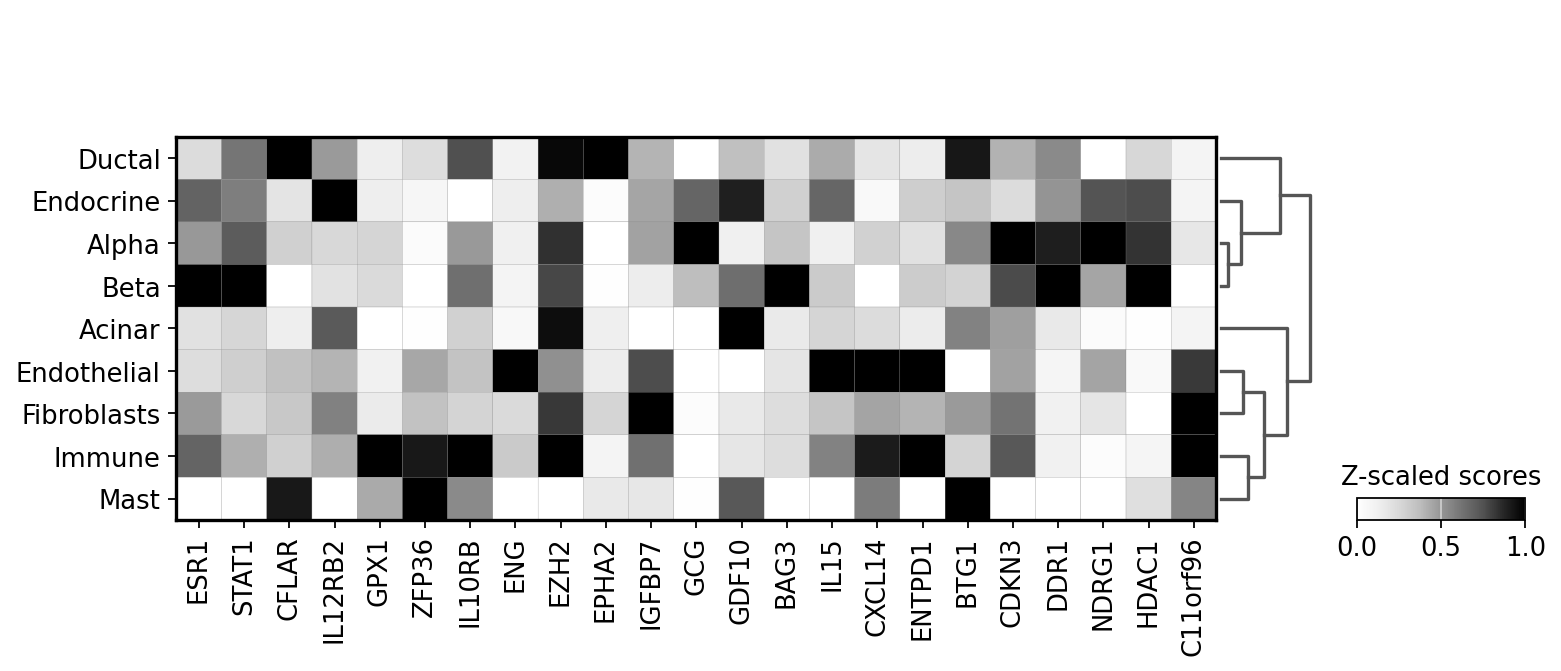

In [87]:
sc.pl.matrixplot(adata, sp['symbol'], 'cell_type_coarse', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='Greys')

In [64]:
adata_ncem = adata[:,np.isin(adata.var_names,significant_points['symbol'])].copy()
adata_ncem

AnnData object with n_obs × n_vars = 4423 × 41
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse'
    var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'spatial', 'cell_type_coarse_colors', 'spatial_neighbors', 'cell_type_coarse_nhood_enrichment', 'cell_type_coarse_interactions', 'cell_type_coarse_ripley_L', 'moranI', 'cell_type_coarse_ligrec', 'ncem

In [68]:
adata_ncem.varm['ncem_fdr_pvals']['index_Mast:neighbor_Alpha']

ADGRA3       7.891279e-04
ADM2         4.900480e-05
AZGP1        2.200083e-05
BEST1        2.163455e-02
CD4          2.878760e-07
CD63         0.000000e+00
CD68         0.000000e+00
CD79A        0.000000e+00
CD80         0.000000e+00
CD81         0.000000e+00
CD84         0.000000e+00
CD9          0.000000e+00
CDKN3        8.016383e-06
COL4A2       2.862283e-03
CRP          2.257738e-03
DUSP1        1.879535e-06
EMP3         3.260053e-07
ENG          2.241494e-04
FGFR2        1.506107e-05
HSPA1A       6.502841e-05
HSPB1        1.099657e-04
IL17RB       3.892967e-02
INHBB        6.081653e-03
ITGB5        0.000000e+00
JAG1         0.000000e+00
JAK1         0.000000e+00
JAK2         0.000000e+00
LAIR1        1.298468e-02
LTBR         2.722002e-02
MECOM        2.046048e-02
PROKR1       1.960015e-05
PSAP         4.815189e-02
PTTG1        2.840808e-02
SMARCB1      3.163901e-02
SPINK1       1.106030e-04
SUCNR1       1.771626e-03
THBS2        2.795928e-08
TNFRSF13B    0.000000e+00
VEGFA       

In [65]:
adata_ncem.X = adata_ncem.varm['ncem_fdr_pvals']
adata_ncem

ValueError: Data matrix has wrong shape (41, 81), need to be (4423, 41).

In [58]:
alpha = 0.0001
np.sum(adata.varm['ncem_fdr_pvals'] < alpha) # and then sort

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


index_Acinar:neighbor_Acinar       21
index_Alpha:neighbor_Acinar        19
index_Beta:neighbor_Acinar         33
index_Ductal:neighbor_Acinar       23
index_Endocrine:neighbor_Acinar    29
                                   ..
index_Endocrine:neighbor_Mast      19
index_Endothelial:neighbor_Mast    32
index_Fibroblasts:neighbor_Mast    21
index_Immune:neighbor_Mast         27
index_Mast:neighbor_Mast           24
Length: 81, dtype: int64

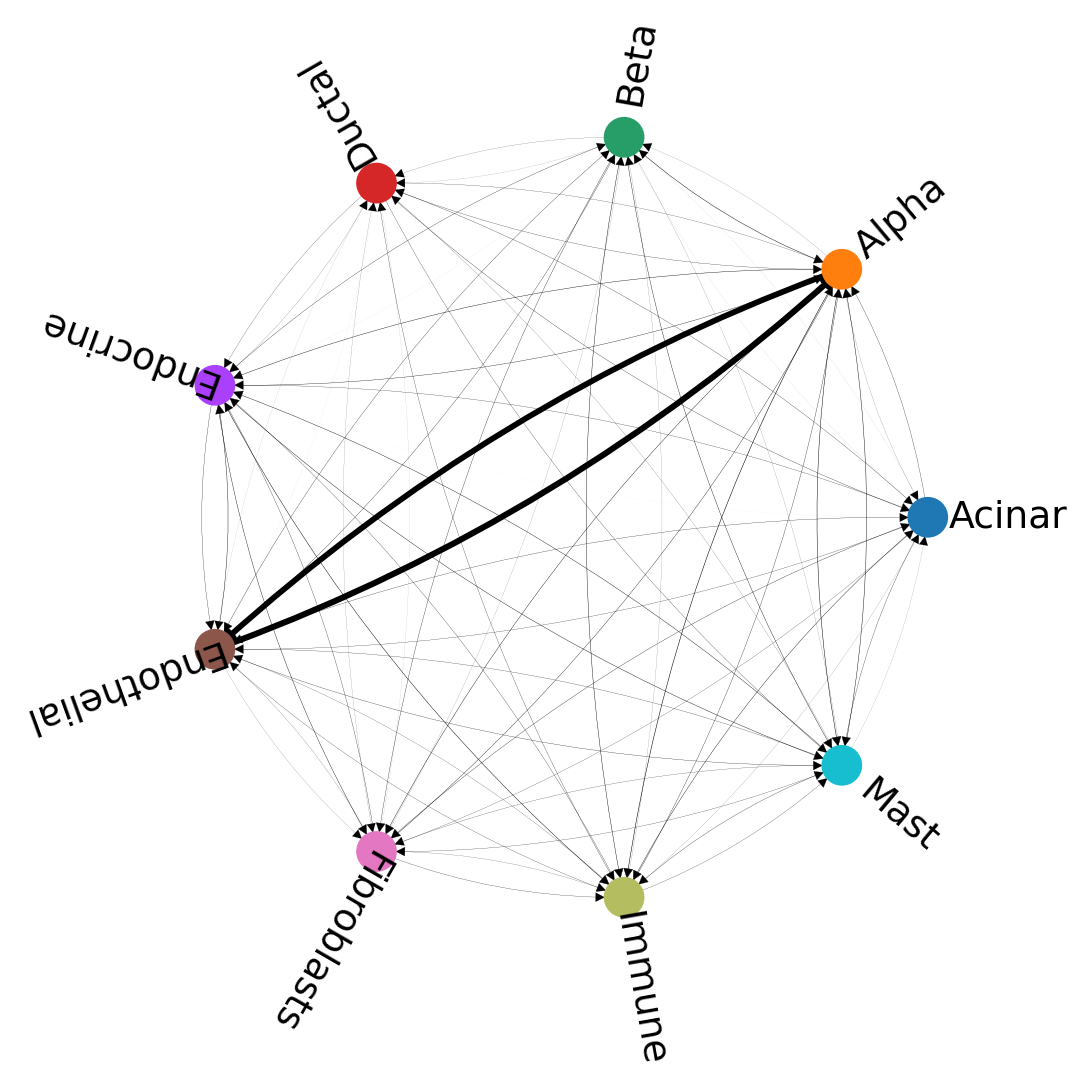

In [62]:
from ncem.pl.type_couplings import circular_rotated_labels
circular_rotated_labels(
    adata, 
    alpha=0.0001, # alpha is threshold when a p-value is considered significant (either 0.01, 0.05, 0.1)
    figsize=(7,7), 
    scale_edge=.1, 
    params_key='ncem_params', 
    pvals_key='ncem_fdr_pvals', 
    edge_type='magnitude', # de_genes ior magnitude
    clip_edges=15 # this value is for plotting reasons --> smaller = more arrows
)

In [ ]:
circular_rotated_labels

In [ ]:
adata.obs.cell_type.cat.categories

In [ ]:
nc.pl.noise_structure(adata,cluster_key='cell_type',figsize=(15,15))

In [ ]:
nc.pl.cluster_freq(adata, cluster_key='cell_type')